In [1]:
import pandas as pd
import glob

# Use glob to get all CSV files starting with "species" in the current directory
csv_files = glob.glob("species*.csv")

# List to hold DataFrames
dfs = []

for file in csv_files:
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Extract label from the filename, e.g., 'species1.csv' -> 'species1'
    label = file.split('.')[0]
    
    # Add the Label column
    df['Label'] = label
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the concatenated DataFrame
print(combined_df.head())

combined_df["Label"]=combined_df["Label"].str.replace("species","")

   FSC-A :: FSC-A  FSC-H :: FSC-H  FSC-T :: FSC-T  FSC-W :: FSC-W  \
0               1               4            1023             175   
1               1               3            1023             113   
2               1               4            1023             151   
3               2               5            1023             174   
4               1               4            1023             150   

   SSC (Imaging)-A :: SSC (Imaging)-A  SSC (Imaging)-H :: SSC (Imaging)-H  \
0                                   0                                   1   
1                                   0                                   1   
2                                   0                                   1   
3                                   0                                   1   
4                                   0                                   1   

   SSC (Imaging)-T :: SSC (Imaging)-T  SSC (Imaging)-W :: SSC (Imaging)-W  \
0                                1023        

<Axes: >

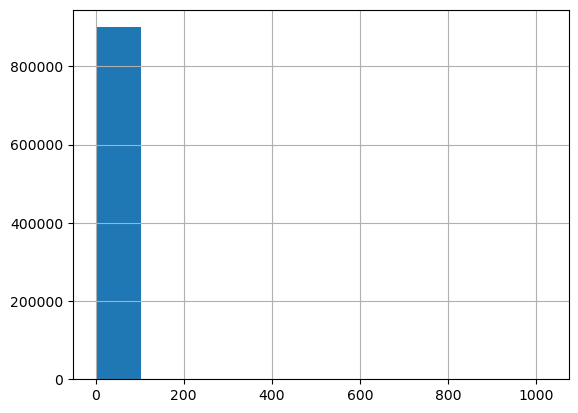

In [9]:
combined_df["YG7 (700)-W :: YG7 (700)-W"].hist(bins=10)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Assume X is your feature matrix (e.g., a NumPy array or pandas DataFrame)
# Create a VarianceThreshold object. Here, threshold=0.0 removes features that have zero variance.
selector = VarianceThreshold(threshold=0.2)
X_reduced = selector.fit_transform(X)

In [7]:
X=combined_df.drop("Label",axis=1).values

In [12]:
combined_df

,FSC-A :: FSC-A,FSC-H :: FSC-H,FSC-T :: FSC-T,FSC-W :: FSC-W,SSC (Imaging)-A :: SSC (Imaging)-A,SSC (Imaging)-H :: SSC (Imaging)-H,SSC (Imaging)-T :: SSC (Imaging)-T,SSC (Imaging)-W :: SSC (Imaging)-W,SSC (Violet)-A :: SSC (Violet)-A,SSC (Violet)-H :: SSC (Violet)-H,...,YG8 (725)-A :: YG8 (725)-A,YG8 (725)-H :: YG8 (725)-H,YG8 (725)-T :: YG8 (725)-T,YG8 (725)-W :: YG8 (725)-W,YG9 (750)-A :: YG9 (750)-A,YG9 (750)-H :: YG9 (750)-H,YG9 (750)-T :: YG9 (750)-T,YG9 (750)-W :: YG9 (750)-W,Time :: Time,Label
0,1,4,1023,175,0,1,1023,230,2,5,...,291,344,143,28,273,337,140,23,0,8
1,1,3,1023,113,0,1,1023,128,1,5,...,267,342,141,20,267,339,135,21,0,8
2,1,4,1023,151,0,1,1023,141,1,3,...,290,363,130,22,288,355,141,23,0,8
3,2,5,1023,174,0,1,1023,185,2,6,...,288,366,145,21,287,358,140,22,0,8
4,1,4,1023,150,0,1,1023,172,2,6,...,291,363,140,22,278,353,135,21,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,0,3,1023,82,0,1,1023,62,1,4,...,240,303,122,17,224,293,127,11,1023,3
899996,0,3,1023,81,0,1,1023,40,1,3,...,248,316,139,18,226,311,139,10,1023,3
899997,0,2,1023,99,1,3,1023,100,4,17,...,225,252,126,18,230,257,133,21,1023,3
899998,0,3,1023,90,0,1,1023,115,1,4,...,220,266,145,11,227,247,137,20,1023,3


In [2]:
# -------------------------------
# 2. Remove Constant Features
# -------------------------------
# Identify constant features (columns with only one unique value)
constant_features = [col for col in combined_df.columns if combined_df[col].nunique() == 1]
print(f"\nFound {len(constant_features)} constant features.")

# Drop constant features to reduce complexity
combined_df=combined_df.drop(columns=constant_features) #+["Time :: Time"]
print("Data shape after removing constant features:", combined_df.shape)


Found 0 constant features.
Data shape after removing constant features: (900000, 421)


In [4]:
import cudf
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score
import cupy as cp  # For any potential GPU array manipulations

# If your concatenated DataFrame is in Pandas, convert it to a cuDF DataFrame:
# combined_df = pd.read_csv('your_concatenated_file.csv')  # If needed
combined_df_gpu = cudf.DataFrame.from_pandas(combined_df)

# Separate features (X) and target (y)
X = combined_df_gpu.drop(columns=["Label"])
y = combined_df_gpu["Label"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using cuML's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Evaluate the classifier using cuML's accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# If you need a confusion matrix, you can convert GPU arrays to host (CPU) using .to_pandas() or .get() (if using cupy)
# Here's an example using Pandas and scikit-learn for the confusion matrix:
from sklearn.metrics import confusion_matrix, classification_report

# Convert GPU arrays to CPU (Pandas) before using scikit-learn utilities:
y_test_cpu = y_test.to_pandas()
y_pred_cpu = y_pred.to_pandas()

print("Confusion Matrix:")
print(confusion_matrix(y_test_cpu, y_pred_cpu))

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred_cpu))

ValueError: cannot create an OBJECT array from memory buffer